## Notebook to analyze video from Evan Ludes with possible pulsating aurora and ground based sound connection

written by Riley Troyer Fall 2021

In [46]:
# Import libraries
import cv2
from matplotlib import animation
from matplotlib import pyplot as plt
import math
import numpy as np
import os
from scipy.signal import savgol_filter
from skimage import io, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
import moviepy.editor as mp
import wave

In [2]:
# Where is the data stored
data_dir = '../data/evan-ludes-aurora-videos/'
filename = 'MVI_1458.MOV'

## First step will be to take a look at one of the frames and see what we are working with

In [3]:
def read_grayscale_frame(video, frame):
    """
    Function to read a frame from a opencv VideoCapture object
    INPUT
    vid_file
        type: OpenCV VideoCapture
        description: The object defining the video the frame is in
    frame
        type: int
        description: The frame number to get
    """
    # Read frame
    video.set(1, frame)
    ret, img = video.read()
    
    # Convert to grayscale assuming frames are in rgb
    gs_img = (img[:, :, 0]*0.2989 
              + img[:, :, 1]*0.5870 
              + img[:, :, 2]*0.1140)
    
    return gs_img

In [4]:
# Read in video
video = cv2.VideoCapture(data_dir + filename)
video_fps = 

In [40]:
# Read in audio file
from moviepy.audio.AudioClip import AudioArrayClip
audio = AudioArrayClip(data_dir + filename, fps=)

TypeError: __init__() missing 1 required positional argument: 'fps'

TypeError: 'AudioFileClip' object is not iterable

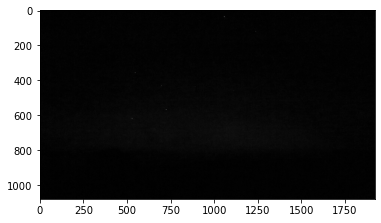

In [5]:
# Plot a frame
frame = 0
gs_img = read_grayscale_frame(video, frame)
plt.imshow(gs_img, cmap='gray')

In [6]:
# Try averaging 3 frame together and see if this is better
avg_img = (read_grayscale_frame(video, 1000) 
             + read_grayscale_frame(video, 1001)
             + read_grayscale_frame(video, 1002))/3

In [7]:
def average_frames(video, start_frame, length):
    """Function to average a number of frames together"""
    
    # Which frames to average
    frames = np.arange(0, length) + start_frame
    
    # Initialize array to sum all frames
    avg_img = read_grayscale_frame(video, start_frame)
    
    # Loop through and add frames to summed array
    for frame in frames[1:]:
        avg_img = avg_img + read_grayscale_frame(video, frame)
        
    # Get average by dividing by length
    avg_img = avg_img/length
    
    return avg_img

In [8]:
avg_img = average_frames(video, 0, 5)

In [9]:
# Try boosting contrast
low = 0.1
high = 99.8

v_min, v_max = np.percentile(avg_img, (low, high))

In [10]:
avg_contrast_img = exposure.rescale_intensity(avg_img, 
                                   in_range=(v_min, v_max))

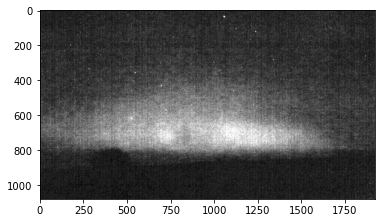

In [11]:
plt.imshow(avg_contrast_img, cmap='gray')

In [12]:
def process_img(frame):
    """Function to process image for animation"""
    
    # Only take every 5 frames as starting frame
    frame = frame + frame*4
    
    # Get the averaged image
    avg_img = average_frames(video, frame, 5)
    
    # Boost the contrast
    low = 0.1
    high = 99.8
    v_min, v_max = np.percentile(average_frames(video, 0, 5),
                                 (low, high))
    avg_img = exposure.rescale_intensity(avg_img, in_range=(v_min, v_max))
    
    return avg_img

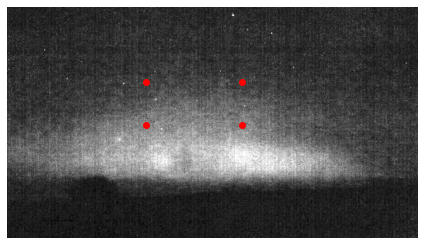

In [19]:
# Create a video with the averaging and contrast boost

# Which start frames to use, will average between these
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
start_frames = np.arange(0, total_frames)[0::5]

# CREATE MOVIE
img_num = len(start_frames) - 1
fps = 6.0


# Construct an animation
# Setup the figure
fig, axpic = plt.subplots(1, 1)

# No axis for images
axpic.axis('off')

# Plot the image
img = axpic.imshow(process_img(0),
                   cmap='gray', animated=True)

axpic.scatter(1100, 550, color='red')
axpic.scatter(1100, 350, color='red')
axpic.scatter(650, 550, color='red')
axpic.scatter(650, 350, color='red')

plt.tight_layout()

# def updatefig(frame):
#     """Function to update the animation"""

#     # Set new image data
#     img.set_data(process_img(frame))

#     return [img]

# # Construct the animation
# anim = animation.FuncAnimation(fig, updatefig,
#                                frames=img_num,
#                                interval=int(1000.0/fps),
#                                blit=True)

# # Close the figure
# plt.close(fig)


# # Use ffmpeg writer to save animation
# event_movie_fn = ('../data/avg-contrast-1458.mp4')
# writer = animation.writers['ffmpeg'](fps=fps)
# anim.save(event_movie_fn,
#           writer=writer, dpi=150)

In [28]:
# Plot average of pixel box for each frame
avg_intensity = np.zeros(total_frames)

for frame in np.arange(0, total_frames):
    
    # Read in the image
    img = read_grayscale_frame(video, frame)
    
    # Get average for pixel box
    avg_intensity[frame] = np.mean(img[350:550, 650:1100])

In [ ]:
smoothed_ = savgol_filter(y, 51, 3)

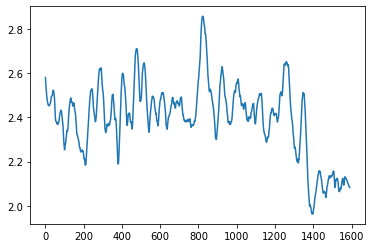

In [31]:
# Calculate the rolling average of the event
avg_intensity_smoothed = savgol_filter(avg_intensity, 51, 3)
frames = np.arange(0, total_frames)

plt.plot(avg_intensity_smoothed)

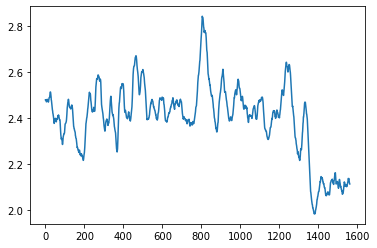

In [29]:
# Calculate the rolling average of the event
N = 30
avg_intensity_smoothed = np.convolve(avg_intensity, np.ones((N,)) / N,
                                   mode='valid')
frames = np.arange(0, total_frames)
frames_smoothed = frames[math.floor(N / 2):-math.floor(N / 2)]

plt.plot(avg_intensity_smoothed)

## Try to get audio

In [43]:
# Read in video using moviepy
video = mp.VideoFileClip(data_dir + filename)

In [45]:
# Extract audio and save as seperate file
video.audio.write_audiofile(r"../data/evan-ludes-aurora-videos/audio-1458.wav")

MoviePy - Writing audio in ../data/evan-ludes-aurora-videos/audio-1458.wav


MoviePy - Done.


In [47]:
# Read in waveform of data
spf = wave.open(data_dir + 'audio-1458.wav', 'r')

In [58]:
signal = spf.readframes(0)
signal = np.fromstring(signal, 'int16')

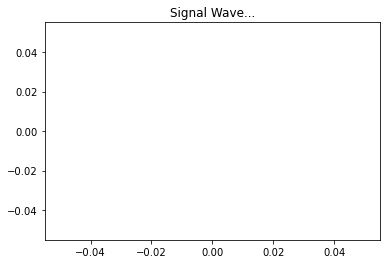

In [54]:
plt.figure(1)
plt.title("Signal Wave...")
plt.plot(signal)
plt.show()

In [59]:
signal

array([], dtype=int16)